#### following this tutorial: https://keras.io/examples/vision/image_classification_from_scratch/

## Setting Up

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
! pip install tf-nightly # nightly builds of the tensorflow master branch released each night

  Using cached h5py-3.1.0-cp37-cp37m-macosx_10_9_x86_64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.2.1
    Uninstalling h5py-3.2.1:
      Successfully uninstalled h5py-3.2.1


## Loading Cats vs Dogs Dataset

### Raw Data Download

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  2683k      0  0:05:00  0:05:00 --:--:-- 5689k1905k      0  0:07:02  0:00:18  0:06:44 2297k 0  2351k      0  0:05:42  0:00:25  0:05:17 3233k     0  1673k      0  0:08:01  0:01:01  0:07:00  136kk      0  0:06:31  0:02:12  0:04:19 2821kk0:05:41  0:04:19  0:01:22 3786k     0  0:05:10  0:04:52  0:00:18 3234k


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

Choosing an Activation Function for Deep Learning (+ How to Implement ReLU).ipynb
Convolutional Neural Network Tutorial.ipynb
Gender Classification Model Project.ipynb
Image Classification Tutorial.ipynb
Iris Data Set Project (Intro to Scikit-learn Model Development Activity).ipynb
Iris Decision Tree Visualization.pdf
MNIST Handwritten Digit Classification Project .ipynb
MSR-LA - 3467.docx
PetImages
Practicing Different NN Architectures with MNIST Dataset.ipynb
Predicting House Prices Project (practice with NNs and Loss Functions).ipynb
Reviewing Python .ipynb
Sarcasm Detection Project (Intro to Making Neural Network Models).ipynb
Sarcasm_Headlines_Dataset_v2.json
age_gender.csv
housepricedata.csv
kagglecatsanddogs_3367a.zip
readme[1].txt
sample_submission.csv
sarcasm_stuff
something tensorflow practice.ipynb
test.csv
train.csv


Now we have a PetImages folder which contains two subfolders: Cat and Dog.  Each subfolder contains image files for each category

In [3]:
!ls PetImages

Cat Dog


### Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


^originally it said that 1590 images were deleted, but once I restarted the kernel and reran it, it says 0 images deleted bc 1590 images were already deleted

## Generate a Dataset

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the Data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

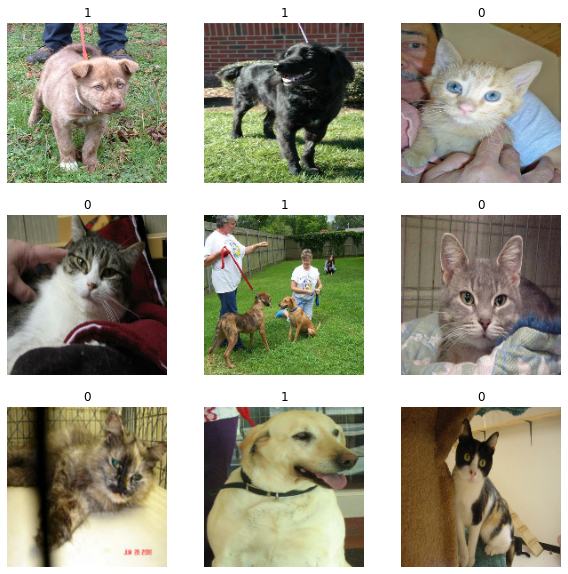

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using Image Data Augmentation

When you don't have a large image dataset, it's good practice to artificially introduce sample diveristy by using augmentation (aka random yet realisitic transformations to the training images.) This helps expose the model to different aspects of the training data while also slowing down overfitting

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the augemented samples look like, by applying data_augmentation repeatedly to the first image

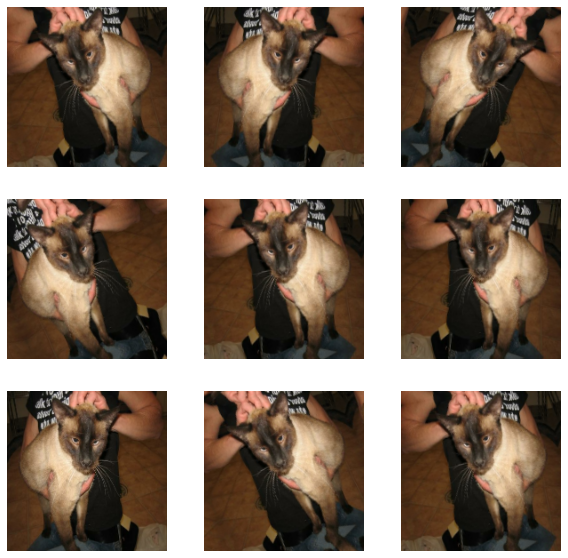

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Two Options to Preprocess the Data

### Option 1:  Make it part of the model:
inputs = keras.Input(shape=input_shape)

x = data_augmentation(inputs)

x = layers.experimental.preprocessing.Rescaling(1./255)(x)

...  # Rest of the model

With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

If you're training on GPU, option 1 is better.

### Option 2: Apply it to the dataset: 

augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

This obtains a dataset that yields batches of augmented images. With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.

#### We'll go with the first option

## Configure the Dataset for Performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model 
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

In [10]:
import pydot
import graphviz

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 2680s 5s/step - loss: 0.6143 - accuracy: 0.6716 - val_loss: 0.9255 - val_accuracy: 0.5348


/Users/lilipiesanen/opt/anaconda3/envs/SureStart/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
586/586 [==============================] - 3112s 5s/step - loss: 0.4533 - accuracy: 0.7897 - val_loss: 0.4508 - val_accuracy: 0.7918
Epoch 3/50
586/586 [==============================] - 4531s 8s/step - loss: 0.3720 - accuracy: 0.8342 - val_loss: 0.3204 - val_accuracy: 0.8631
Epoch 4/50
586/586 [==============================] - 4660s 8s/step - loss: 0.3120 - accuracy: 0.8663 - val_loss: 0.3563 - val_accuracy: 0.8486
Epoch 5/50
586/586 [==============================] - 4190s 7s/step - loss: 0.2623 - accuracy: 0.8904 - val_loss: 0.2623 - val_accuracy: 0.8885
Epoch 6/50
586/586 [==============================] - 4968s 8s/step - loss: 0.2264 - accuracy: 0.9043 - val_loss: 0.5274 - val_accuracy: 0.7809
Epoch 7/50
586/586 [==============================] - 8061s 14s/step - loss: 0.2038 - accuracy: 0.9146 - val_loss: 0.2776 - val_accuracy: 0.8885
Epoch 8/50
586/586 [==============================] - 2763s 5s/step - loss: 0.1832 - accuracy: 0.9265 - val_loss: 0.1850 - val_accuracy

## Run Inference on New Data

In [13]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 91.61 percent cat and 8.39 percent dog.


In [14]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6778.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.98 percent cat and 0.02 percent dog.


In [15]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/67.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.87 percent cat and 0.13 percent dog.


In [17]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6300.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 100.00 percent cat and 0.00 percent dog.


In [18]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/3.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.74 percent cat and 0.26 percent dog.
